Mounted at /content/drive

t-SNE VISUALIZATION: GAP vs TPA

EXPERIMENT: WALKING_TO_UPSTAIRS_20pct

Loading WALKING_TO_UPSTAIRS_20pct...
  Path: /content/drive/MyDrive/AI_data/TPA2/wisdm_transition_datasets/WALKING_TO_UPSTAIRS_20pct
  Train: (24156, 200, 3), Test: (6040, 200, 3)

Dataset splits:
  Train: 19324, Val: 4832, Test: 6040

[GAP] Walking to Upstairs (20%)

[Training GAP]
  Epoch  10: Train Acc=0.9620, Val Acc=0.9615, F1=0.9377
  Epoch  20: Train Acc=0.9826, Val Acc=0.9818, F1=0.9682
  Epoch  30: Train Acc=0.9878, Val Acc=0.9872, F1=0.9766
  Epoch  40: Train Acc=0.9917, Val Acc=0.9884, F1=0.9802
  Epoch  50: Train Acc=0.9929, Val Acc=0.9907, F1=0.9851
  Epoch  60: Train Acc=0.9938, Val Acc=0.9894, F1=0.9816
  Epoch  70: Train Acc=0.9952, Val Acc=0.9901, F1=0.9840
  Epoch  80: Train Acc=0.9961, Val Acc=0.9915, F1=0.9862
  Epoch  90: Train Acc=0.9965, Val Acc=0.9919, F1=0.9867
  Early stopping at epoch 93
  Best Val Acc: 0.9921

[GAP Results]
  Val Acc: 0.9921
  Test Acc: 0.9911,

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  ✓ Saved: /content/drive/MyDrive/AI_data/TPA2/tsne_visualizations/wisdm_tsne_WALKING_TO_UPSTAIRS_20pct_GAP.png


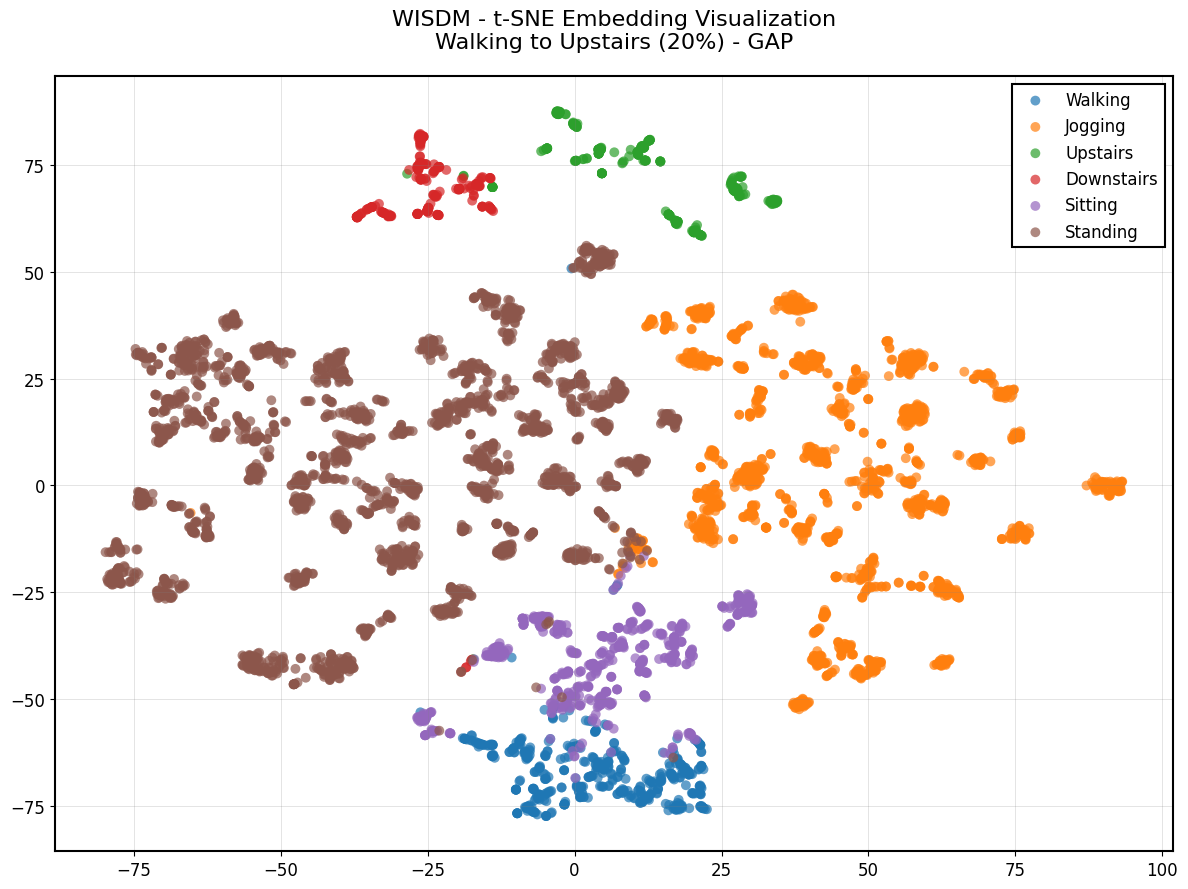


✓ Completed GAP


[TPA] Walking to Upstairs (20%)

[Training TPA]
  Epoch  10: Train Acc=0.9926, Val Acc=0.9837, F1=0.9695
  Epoch  20: Train Acc=0.9967, Val Acc=0.9843, F1=0.9701
  Epoch  30: Train Acc=0.9980, Val Acc=0.9845, F1=0.9711
  Epoch  40: Train Acc=0.9983, Val Acc=0.9839, F1=0.9711
  Early stopping at epoch 42
  Best Val Acc: 0.9863

[TPA Results]
  Val Acc: 0.9863
  Test Acc: 0.9844, F1: 0.9751

[Generating t-SNE]
  Feature shape: (6040, 128)
  Applying t-SNE for TPA...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


  ✓ Saved: /content/drive/MyDrive/AI_data/TPA2/tsne_visualizations/wisdm_tsne_WALKING_TO_UPSTAIRS_20pct_TPA.png


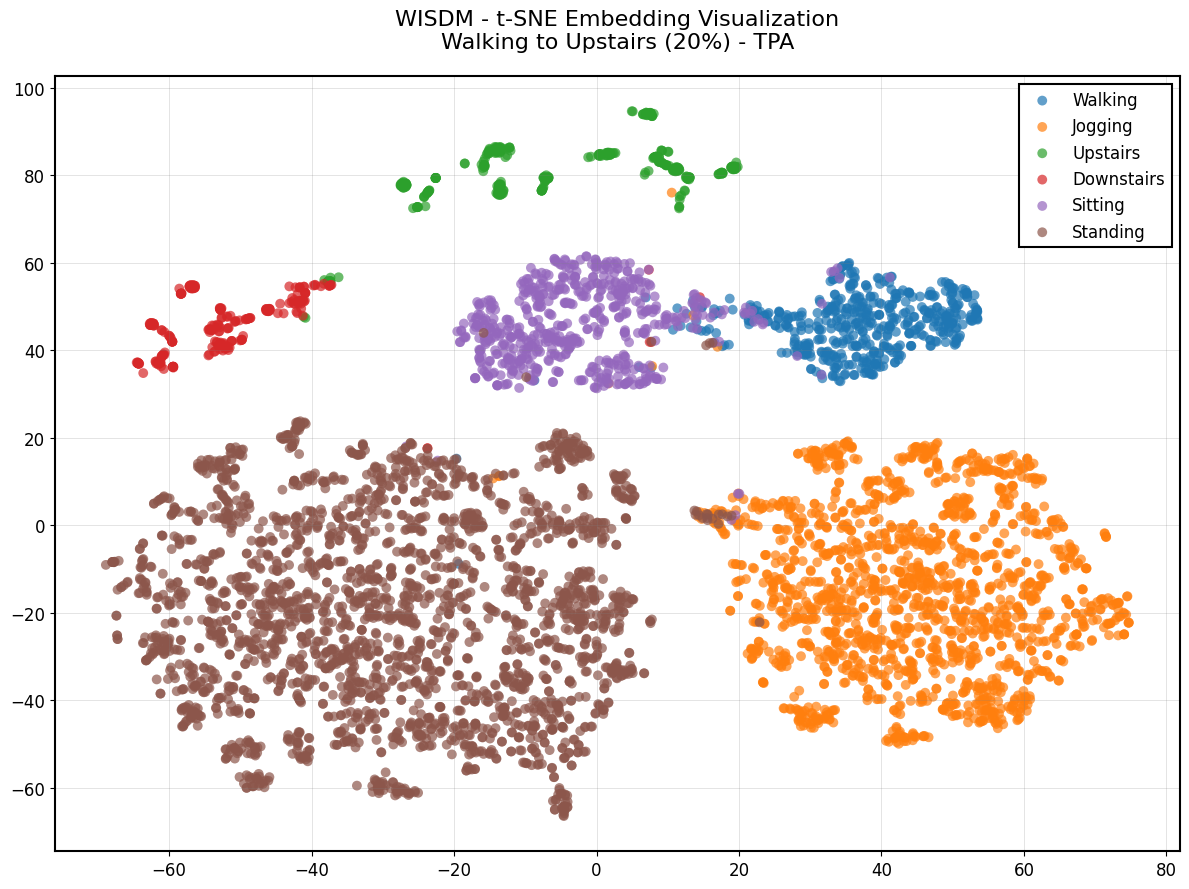


✓ Completed TPA


FINAL SUMMARY
WALKING_TO_UPSTAIRS_20pct                | GAP          | F1: 0.9861
WALKING_TO_UPSTAIRS_20pct                | TPA          | F1: 0.9751

✓ ALL t-SNE VISUALIZATIONS COMPLETE!
Results saved to: /content/drive/MyDrive/AI_data/TPA2/tsne_visualizations


In [1]:
# -*- coding: utf-8 -*-
"""Unified Model Comparison: GAP, TPA
"""

from google.colab import drive
drive.mount('/content/drive')

import os, random, time, copy, json
import numpy as np
from typing import Tuple, Dict, List
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# ========================
# Config & Reproducibility
# ========================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

@dataclass
class Config:
    data_dir: str = "/content/drive/MyDrive/AI_data/TPA2/wisdm_transition_datasets"
    save_dir: str = "/content/drive/MyDrive/AI_data/TPA2"

    epochs: int = 100
    batch_size: int = 128
    lr: float = 1e-4
    weight_decay: float = 1e-4
    grad_clip: float = 1.0
    label_smoothing: float = 0.05

    patience: int = 20
    min_delta: float = 0.0001
    val_split: float = 0.2

    d_model: int = 128

    # TPA hyperparameters
    tpa_num_prototypes: int = 16
    tpa_heads: int = 4
    tpa_dropout: float = 0.1
    tpa_temperature: float = 0.07
    tpa_topk_ratio: float = 0.25

    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers: int = 2

cfg = Config()

# ========================
# Dataset Class
# ========================
class PreloadedDataset(Dataset):
    """Dataset for pre-loaded numpy arrays"""
    def __init__(self, X: np.ndarray, y: np.ndarray):
        super().__init__()
        self.X = torch.from_numpy(X).float()

        # Label 범위 확인 및 조정 (1-6 -> 0-5)
        if y.min() >= 1:
            y = y - 1

        self.y = torch.from_numpy(y).long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ========================
# Data Loading Functions
# ========================
def load_dataset(base_dir: str, dataset_name: str):
    """
    Load pre-augmented dataset
    Args:
        base_dir: base directory containing all datasets
        dataset_name: e.g., "ORIGINAL", "STANDING_TO_SITTING_10pct", etc.
    Returns:
        train_dataset, test_dataset
    """
    dataset_dir = os.path.join(base_dir, dataset_name)

    print(f"\nLoading {dataset_name}...")
    print(f"  Path: {dataset_dir}")

    # Load data
    X_train = np.load(os.path.join(dataset_dir, "X_train.npy"))
    y_train = np.load(os.path.join(dataset_dir, "y_train.npy"))
    X_test = np.load(os.path.join(dataset_dir, "X_test.npy"))
    y_test = np.load(os.path.join(dataset_dir, "y_test.npy"))

    print(f"  Train: {X_train.shape}, Test: {X_test.shape}")

    train_dataset = PreloadedDataset(X_train, y_train)
    test_dataset = PreloadedDataset(X_test, y_test)

    return train_dataset, test_dataset

# ========================
# Model Components
# ========================
class ConvBNAct(nn.Module):
    def __init__(self, c_in, c_out, k, s=1, p=None, g=1):
        super().__init__()
        self.c = nn.Conv1d(c_in, c_out, k, s, k//2 if p is None else p, groups=g, bias=False)
        self.bn = nn.BatchNorm1d(c_out)
        self.act = nn.GELU()

    def forward(self, x):
        return self.act(self.bn(self.c(x)))

class MultiPathCNN(nn.Module):
    """Shared backbone for all models"""
    def __init__(self, in_ch=3, d_model=128, branches=(3,5,9,15), stride=2):
        super().__init__()
        h = d_model // 2
        self.pre = ConvBNAct(in_ch, h, 1)
        self.branches = nn.ModuleList([
            nn.Sequential(ConvBNAct(h, h, k, stride, g=h), ConvBNAct(h, h, 1))
            for k in branches
        ])
        self.post = ConvBNAct(len(branches)*h, d_model, 1)

    def forward(self, x):
        return self.post(torch.cat([b(self.pre(x)) for b in self.branches], dim=1))

# ========================
# GAP Model
# ========================
class GAPModel(nn.Module):
    """Baseline: Global Average Pooling"""
    def __init__(self, d_model=128, num_classes=6):
        super().__init__()
        self.backbone = MultiPathCNN(d_model=d_model)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x shape: [B, T, C] -> transpose to [B, C, T] for Conv1d
        x = x.transpose(1, 2)  # [B, C, T]
        fmap = self.backbone(x)  # [B, D, T]
        features = fmap.transpose(1, 2)  # [B, T, D]
        pooled = features.mean(dim=1)  # [B, D]
        logits = self.fc(pooled)
        return logits

# ========================
# Pure-TPA
# ========================
class ProductionTPA(nn.Module):
    """Pure TPA"""
    def __init__(self, dim, num_prototypes=16, heads=4, dropout=0.1,
                 temperature=0.07, topk_ratio=0.25):
        super().__init__()
        assert dim % heads == 0

        self.dim = dim
        self.heads = heads
        self.head_dim = dim // heads
        self.num_prototypes = num_prototypes
        self.temperature = temperature
        self.topk_ratio = topk_ratio

        self.proto = nn.Parameter(torch.randn(num_prototypes, dim) * 0.02)

        self.pre_norm = nn.LayerNorm(dim)

        self.q_proj = nn.Linear(dim, dim, bias=False)
        self.k_proj = nn.Linear(dim, dim, bias=False)
        self.v_proj = nn.Linear(dim, dim, bias=False)

        self.fuse = nn.Sequential(
            nn.Linear(dim, dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, D = x.shape
        P = self.num_prototypes

        x_norm = self.pre_norm(x)

        K = self.k_proj(x_norm)
        V = self.v_proj(x_norm)
        Qp = self.q_proj(self.proto).unsqueeze(0).expand(B, -1, -1)

        def split_heads(t, length):
            return t.view(B, length, self.heads, self.head_dim).transpose(1, 2)

        Qh = split_heads(Qp, P)
        Kh = split_heads(K, T)
        Vh = split_heads(V, T)

        Qh = F.normalize(Qh, dim=-1)
        Kh = F.normalize(Kh, dim=-1)

        scores = torch.matmul(Qh, Kh.transpose(-2, -1)) / self.temperature
        attn = F.softmax(scores, dim=-1)
        attn = torch.nan_to_num(attn, nan=0.0)
        attn = self.dropout(attn)

        proto_tokens = torch.matmul(attn, Vh)
        proto_tokens = proto_tokens.transpose(1, 2).contiguous().view(B, P, D)

        z_tpa = proto_tokens.mean(dim=1)

        z = self.fuse(z_tpa)

        return z

class TPAModel(nn.Module):
    def __init__(self, d_model=128, num_classes=6, tpa_config=None):
        super().__init__()
        self.backbone = MultiPathCNN(d_model=d_model)
        self.tpa = ProductionTPA(
            dim=d_model,
            num_prototypes=tpa_config['num_prototypes'],
            heads=tpa_config['heads'],
            dropout=tpa_config['dropout'],
            temperature=tpa_config['temperature'],
            topk_ratio=tpa_config['topk_ratio']
        )
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x shape: [B, T, C] -> transpose to [B, C, T] for Conv1d
        x = x.transpose(1, 2)  # [B, C, T]
        fmap = self.backbone(x)  # [B, D, T]
        features = fmap.transpose(1, 2)  # [B, T, D]
        z = self.tpa(features)  # [B, D]
        logits = self.classifier(z)
        return logits


# ========================
# Training & Evaluation
# ========================
def train_one_epoch(model, loader, opt, cfg: Config):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0

    for x, y in loader:
        x, y = x.to(cfg.device).float(), y.to(cfg.device)

        opt.zero_grad(set_to_none=True)
        logits = model(x)

        loss = F.cross_entropy(logits, y, label_smoothing=cfg.label_smoothing)
        if torch.isnan(loss):
            continue

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
        opt.step()

        with torch.no_grad():
            pred = logits.argmax(dim=-1)
            correct += (pred == y).sum().item()
            total += y.size(0)
            loss_sum += loss.item() * y.size(0)

    return {
        "loss": loss_sum / total if total > 0 else 0,
        "acc": correct / total if total > 0 else 0
    }

@torch.no_grad()
def evaluate(model, loader, cfg: Config):
    model.eval()
    ys, ps = [], []

    for x, y in loader:
        x, y = x.to(cfg.device), y.to(cfg.device)
        logits = model(x)
        ps.append(logits.argmax(dim=-1).cpu().numpy())
        ys.append(y.cpu().numpy())

    y_true, y_pred = np.concatenate(ys), np.concatenate(ps)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    return acc, f1

def train_model(model, train_loader, val_loader, cfg: Config, model_name: str):
    """Train a single model"""
    print(f"\n[Training {model_name}]")

    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    best_acc, best_wts = 0.0, None
    patience_counter = 0

    for epoch in range(1, cfg.epochs + 1):
        stats = train_one_epoch(model, train_loader, opt, cfg)
        val_acc, val_f1 = evaluate(model, val_loader, cfg)

        if val_acc > best_acc + cfg.min_delta:
            best_acc = val_acc
            best_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 10 == 0:
            print(f"  Epoch {epoch:3d}: Train Acc={stats['acc']:.4f}, Val Acc={val_acc:.4f}, F1={val_f1:.4f}")

        if patience_counter >= cfg.patience:
            print(f"  Early stopping at epoch {epoch}")
            break

    if best_wts:
        model.load_state_dict(best_wts)

    print(f"  Best Val Acc: {best_acc:.4f}")
    return best_acc

def create_model(model_name: str, cfg: Config):
    """Create model by name"""
    tpa_config = {
        'num_prototypes': cfg.tpa_num_prototypes,
        'heads': cfg.tpa_heads,
        'dropout': cfg.tpa_dropout,
        'temperature': cfg.tpa_temperature,
        'topk_ratio': cfg.tpa_topk_ratio
    }

    if model_name == "GAP":
        return GAPModel(d_model=cfg.d_model).to(cfg.device).float()
    elif model_name == "TPA":
        return TPAModel(d_model=cfg.d_model, tpa_config=tpa_config).to(cfg.device).float()
    else:
        raise ValueError(f"Unknown model: {model_name}")


# ========================
# Feature Extraction for t-SNE
# ========================
def extract_features(model, dataloader, device, model_name):
    """
    Extract features before final classification layer
    """
    model.eval()
    features_list = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            x = inputs.to(device).float()
            x = x.transpose(1, 2)  # [B, T, C] -> [B, C, T]

            fmap = model.backbone(x)  # [B, C, T]
            features = fmap.transpose(1, 2)  # [B, T, C]

            # 모델 타입에 따라 최종 풀링된 특성 추출
            if model_name == "GAP":
                z = features.mean(dim=1)  # GAP
            elif model_name == "TPA":
                z = model.tpa(features)  # Pure TPA output [B, D]
            else:
                 raise ValueError(f"Unknown model for feature extraction: {model_name}")

            features_list.append(z.cpu().numpy())
            labels_list.append(labels.numpy())

    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    return features, labels

def plot_tsne(features, labels, model_name, dataset_name, display_name, test_f1, cfg):
    """
    Create and save t-SNE visualization
    """
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE

    print(f"  Applying t-SNE for {model_name}...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    features_2d = tsne.fit_transform(features)

    # Activity labels mapping (WISDM dataset)
    activity_names = {
        0: 'Walking',
        1: 'Jogging',
        2: 'Upstairs',
        3: 'Downstairs',
        4: 'Sitting',
        5: 'Standing'
    }

    # Create plot with white background
    fig, ax = plt.subplots(1, 1, figsize=(12, 9))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # Plot each class separately for better legend
    unique_labels = np.unique(labels)
    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    for label in unique_labels:
        mask = labels == label
        ax.scatter(features_2d[mask, 0], features_2d[mask, 1],
                  c=[colors[label]], label=activity_names.get(label, f'Class {label}'),
                  alpha=0.7, s=50, edgecolors='none')

    # Title
    ax.set_title(f'WISDM - t-SNE Embedding Visualization\n{display_name} - {model_name}',
                fontsize=16, fontweight='normal', pad=20)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelsize=12)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, color='gray')

    legend = ax.legend(loc='upper right', fontsize=12, frameon=True,
                      fancybox=False, shadow=False, framealpha=1,
                      edgecolor='black', facecolor='white')
    legend.get_frame().set_linewidth(1.5)

    x_margin = (features_2d[:, 0].max() - features_2d[:, 0].min()) * 0.05
    y_margin = (features_2d[:, 1].max() - features_2d[:, 1].min()) * 0.05
    ax.set_xlim(features_2d[:, 0].min() - x_margin, features_2d[:, 0].max() + x_margin)
    ax.set_ylim(features_2d[:, 1].min() - y_margin, features_2d[:, 1].max() + y_margin)

    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)

    plt.tight_layout()

    tsne_save_dir = os.path.join(cfg.save_dir, "tsne_visualizations")
    os.makedirs(tsne_save_dir, exist_ok=True)

    safe_name = dataset_name.replace('/', '_').replace(' ', '_')
    save_path = os.path.join(tsne_save_dir, f"wisdm_tsne_{safe_name}_{model_name}.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"  ✓ Saved: {save_path}")

    plt.show()
    plt.close()

# ========================
# Modified run_experiment with t-SNE
# ========================
def run_experiment_with_tsne(dataset_name: str, display_name: str, cfg) -> List[Dict]:
    """
    Run experiment and generate t-SNE visualizations
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"\n{'='*80}")
    print(f"EXPERIMENT: {dataset_name}")
    print(f"{'='*80}")

    train_dataset, test_dataset = load_dataset(cfg.data_dir, dataset_name)

    n_total = len(train_dataset)
    indices = np.arange(n_total)
    y_labels = train_dataset.y.numpy()

    train_indices, val_indices = train_test_split(
        indices, test_size=cfg.val_split, random_state=SEED, stratify=y_labels
    )

    from torch.utils.data import Subset
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(train_dataset, val_indices)

    g = torch.Generator(device='cpu').manual_seed(SEED)
    train_loader = DataLoader(train_subset, cfg.batch_size, shuffle=True,
                              num_workers=cfg.num_workers, generator=g)
    val_loader = DataLoader(val_subset, cfg.batch_size, num_workers=cfg.num_workers)
    test_loader = DataLoader(test_dataset, cfg.batch_size, num_workers=cfg.num_workers)

    print(f"\nDataset splits:")
    print(f"  Train: {len(train_subset)}, Val: {len(val_subset)}, Test: {len(test_dataset)}")

    results = []
    model_names = ["GAP", "TPA"]

    for model_name in model_names:
        print(f"\n{'='*80}")
        print(f"[{model_name}] {display_name}")
        print(f"{'='*80}")

        random.seed(SEED)
        np.random.seed(SEED)
        torch.manual_seed(SEED)

        model = create_model(model_name, cfg)
        best_val_acc = train_model(model, train_loader, val_loader, cfg, model_name)
        test_acc, test_f1 = evaluate(model, test_loader, cfg)

        print(f"\n[{model_name} Results]")
        print(f"  Val Acc: {best_val_acc:.4f}")
        print(f"  Test Acc: {test_acc:.4f}, F1: {test_f1:.4f}")

        results.append({
            'Model': model_name,
            'Dataset': dataset_name,
            'Val_Accuracy': float(best_val_acc),
            'Test_Accuracy': float(test_acc),
            'Test_F1_Score': float(test_f1)
        })

        print(f"\n[Generating t-SNE]")
        features, labels = extract_features(model, test_loader, device, model_name)
        print(f"  Feature shape: {features.shape}")

        plot_tsne(features, labels, model_name, dataset_name, display_name, test_f1, cfg)

        print(f"\n✓ Completed {model_name}\n")

    return results

# ========================
# Run t-SNE for Selected Transitions
# ========================
if __name__ == "__main__":
    print("\n" + "="*80)
    print("t-SNE VISUALIZATION: GAP vs TPA")
    print("="*80)

    results = run_experiment_with_tsne(
        dataset_name='WALKING_TO_UPSTAIRS_20pct',
        display_name='Walking to Upstairs (20%)',
        cfg=cfg
    )

    print("\n" + "="*80)
    print("FINAL SUMMARY")
    print("="*80)
    for result in results:
        print(f"{result['Dataset']:40s} | {result['Model']:12s} | F1: {result['Test_F1_Score']:.4f}")

    print("\n" + "="*80)
    print("✓ ALL t-SNE VISUALIZATIONS COMPLETE!")
    print(f"Results saved to: {os.path.join(cfg.save_dir, 'tsne_visualizations')}")
    print("="*80)